## Description

* Multinomial Bimodal Topic Model (Properties $\sim$ Multinomial)

## I. Prepare Input

* norms: list of all McRae norms (541)
* props: list of all McRae properties (2526)
* norm2prop: norm -> prop mapping
* corpus triples: (word, dep, head)

In [57]:
import cPickle

In [58]:
norms,norm2prop,norm2propprob,props = cPickle.load(open("/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/DATA/MCRAE/mcare_norm_data.p",'rb'))
dep_triples = cPickle.load(open("/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/DATA/BROWN/brown_triples.p",'rb'))

In [59]:
norms = list(set(norms)) # ignore polysemy.

## II. Facilities

In [60]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy
from itertools import chain
from __future__ import division
from operator import add
from collections import Counter, defaultdict
from sklearn.metrics import average_precision_score

In [61]:
# HELPERs

def normalize(arr):
    return arr / arr.sum()

def partition(l, k):
    k = max(1, k)
    chunk_size = len(l)//k
    return [l[i:i+chunk_size] for i in xrange(0, len(l), chunk_size)]

In [93]:
# EVALUATORS

def topk_evaluate(norm2propdist, k): # test norms.
    accuracies = []
    for norm in norm2propdist.iterkeys():
        true_props = norm2prop[norm]
        pred_props = map(lambda idx:props[idx], np.argsort(norm2propdist[norm])[::-1][:k])
        accuracy = 0.
        for pred_prop in pred_props:
            if pred_prop in true_props: 
                accuracy = 1. # gold-standard prop retrieved, count 'accuracy'.
                break
        accuracies.append(accuracy)
    print "Percentage Accurate (Test Norms) in Top %d Predictions: %.6f%%" % (k, np.mean(accuracies)*100)

def map_evaluate(norm2propdist):
    avg_precs = []
    for norm in norm2propdist.iterkeys():
        true_propbin = np.array([1 if prop in norm2prop[norm] else 0 for prop in props])
        pred_propdist = norm2propdist[norm]
        avg_precs.append(average_precision_score(true_propbin, pred_propdist))
    print "MAP: %.6f%%" % (np.mean(avg_precs)*100)
    
def map_ranker(norm2propdist):
    norm2ap_tuples = []
    for norm in norm2propdist.iterkeys():
        true_propbin = np.array([1 if prop in norm2prop[norm] else 0 for prop in props])
        pred_propdist = norm2propdist[norm]
        norm2ap_tuples.append((norm,average_precision_score(true_propbin, pred_propdist)))
    norm_by_ap = sorted(norm2ap_tuples, key=lambda x:x[1], reverse=True)
    print "Top 20 norms by AP:"
    print pd.DataFrame(norm_by_ap[:20], columns=['Concepts','AP'])
    print "Bottom 20 norms by AP:"
    print pd.DataFrame(norm_by_ap[-20:], columns=['Concepts','AP'])
    print "Standard Deviation of APs:"
    print np.std(map(lambda (n,ap):ap, norm2ap_tuples))
    
def get_stats(norm2propdist_list): # norm2propdist_list: "results" from infer
    # 1. rank norms by AP: all norms, top 20 and bottom 20.
    # 2. property distinctiveness (top 10 predicted properties, each norm gets top 5 predictions).
    # 3. property rank of selected norms: ['cat','alligator','book','cigarette','drain','gate']
    all_norm2ap_tuples = []
    all_pred_props = []
    selected_norms = ['cat','alligator','book','cigarette','drain','gate']
    selected_norm_top_df, selected_norm_bottom_df = pd.DataFrame(), pd.DataFrame() # 3
    for norm2propdist in norm2propdist_list:
        norm2ap_tuples = []
        for norm in norm2propdist.iterkeys():
            true_propbin = np.array([1 if prop in norm2prop[norm] else 0 for prop in props])
            pred_propdist = norm2propdist[norm]
            all_pred_props += map(lambda idx:props[idx], np.argsort(pred_propdist)[::-1][:5])
            norm2ap_tuples.append((norm,average_precision_score(true_propbin, pred_propdist)))
            if norm in selected_norms:
                top20 = map(lambda idx:props[idx], np.argsort(pred_propdist)[::-1][:20])
                bottom20 = map(lambda idx:props[idx], np.argsort(pred_propdist)[::-1][-20:])
                selected_norm_top_df[str(norm)] = top20
                selected_norm_bottom_df[str(norm)] = bottom20
        all_norm2ap_tuples += norm2ap_tuples
    all_norm_by_ap = sorted(all_norm2ap_tuples, key=lambda x:x[1], reverse=True)
    all_aps = map(lambda x:x[1], all_norm_by_ap) # 1
    top20norms_by_ap = pd.DataFrame(all_norm_by_ap[:20], columns=['Concepts','AP']) # 1
    bottom20norms_by_ap = pd.DataFrame(all_norm_by_ap[-20:], columns=['Concepts','AP']) # 1
    top10predprops = Counter(all_pred_props).most_common(10) # type=tuple
    prop_count_distinct_tuples = []
    prop2distinct = distinctiveness()
    for prop,count in top10predprops:
        prop_count_distinct_tuples.append((prop,count,prop2distinct[prop]))
    top10predprops_df = pd.DataFrame(prop_count_distinct_tuples, columns=['Feature','Count','Distinctiveness']) # 2
    overall_ap_std = np.std(map(lambda (n,ap):ap, all_norm2ap_tuples)) 
    
    return all_aps, top20norms_by_ap, bottom20norms_by_ap, \
           top10predprops_df, \
           selected_norm_top_df, selected_norm_bottom_df

In [69]:
# OTHER EVALUATORS

def distinctiveness():
    prop2numnorms = defaultdict(int)
    for norm in norms:
        props = norm2prop[norm]
        for prop in props:
            prop2numnorms[prop] += 1
    prop2distinct = {prop:1/prop2numnorms[prop] for prop in prop2numnorms.iterkeys()}
    return prop2distinct

##### Inference Math

* Given a new word $u$ is observed, in a corpus $\mathcal{C}$, to have been the argument of a set of VR pairs $VR=\{vr:pred(vr,u)\in\mathcal{C}\}$. Then, the PDF of the distribution over properties $f\in F$ conditioned on $VR$ is 
$$p(f\mid VR)=\sum_{z}p(f\mid z)p(z\mid VR)$$
where $$p(z\mid VR) = \sum_{vr\in VR}p(z\mid vr)$$

In [51]:
class WPMBTM:
    
    def __init__(self, norms, props, norm2prop, norm2propprob, triples):
        self.all_norms = norms # train-test split later.
        self.props = props
        self.n2i = {n:i for i,n in enumerate(self.all_norms)} # indexing pseudo-docs, each corresponds to 1 train norm.
        self.f2i = {f:i for i,f in enumerate(self.props)}
        self.norm2prop = norm2prop
        self.norm2propprob = norm2propprob
        self.triples = triples
        self.preprocessing()
 
    def preprocessing(self):
        # construct norm2vr and norm2f mappings.
        all_norms_set = set(self.all_norms) # for fast lookup.
        self.norm2vr_f = defaultdict(lambda : defaultdict(list))
        for norm,dep,head in self.triples:
            if norm in all_norms_set and (dep=='nsubj' or dep=='dobj'):
                vr = head+'-'+dep
                f = np.random.choice(self.norm2prop[norm],p=self.norm2propprob[norm])
                self.norm2vr_f[norm]['vr'].append(vr)
                self.norm2vr_f[norm]['f'].append(f)
        self.all_norms = self.norm2vr_f.keys() # narrow it down to norms appearing in the current corpus.
        
    def learn(self, train_norms, topics):
        # make pseudo-documents.
        vrs = set() 
        norm2vr_f = deepcopy(self.norm2vr_f) # avoid subtle changes to the original mapping dict.
        word_docs, prop_docs = [], [] # word_docs: for v-r pairs.
        for norm in train_norms:
            word_docs.append(norm2vr_f[norm]['vr'])
            prop_docs.append(norm2vr_f[norm]['f'])
            vrs = vrs.union(set(norm2vr_f[norm]['vr']))
        vrs = list(vrs)
        w2i = {vr:i for i,vr in enumerate(vrs)} 
        for word_doc,prop_doc in zip(word_docs,prop_docs):
            for i,(word,prop) in enumerate(zip(word_doc,prop_doc)):
                sampled_topic = np.random.choice(topics)
                word_doc[i] = (word,sampled_topic)
                prop_doc[i] = (prop,sampled_topic)
        # topic modeling
        print "... Running Topic Model"
        W, F, D, T = len(vrs), len(self.props), len(word_docs), len(topics)
        alpha, beta, gamma = 50/2, .001, .001
        alpha_arr = np.array([alpha for _ in range(T)]); Talpha_arr = np.array([alpha*T for _ in range(T)])
        beta_arr = np.array([beta for _ in range(T)]); Wbeta_arr = np.array([beta*W for _ in range(T)])
        gamma_arr = np.array([gamma for _ in range(T)]); Fgamma_arr = np.array([gamma*F for _ in range(T)])
        C_WT, C_FT, C_DT = np.zeros((W,T)), np.zeros((F,T)), np.zeros((D,T))
        wt_counts = reduce(add,[Counter(word_doc) for word_doc in word_docs])
        ft_counts = reduce(add,[Counter(prop_doc) for prop_doc in prop_docs])
        for (w,t_w),wt_count in wt_counts.iteritems(): C_WT[w2i[w]][t_w] = wt_count 
        for (f,t_f),ft_count in ft_counts.iteritems(): C_FT[self.f2i[f]][t_f] = ft_count
        for i,doc in enumerate(word_docs): # word,property pairs have the same topic assignments.
            dt_counts = Counter([t for w,t in doc])
            for j in range(T):
                C_DT[i][j] = dt_counts[j]
        if not C_WT.sum()==C_FT.sum()==C_DT.sum():
            raise Exception, "Error in counts in pseudo-document."
        def sample_topic(w_i,f_i,d): # defined locally to avoid passing around big matrices.
            P_num_arr = (C_WT[w_i,:]+beta_arr) * (C_FT[f_i,:]+gamma_arr) * (C_DT[d,:]+alpha_arr)
            P_denom_arr = (np.apply_along_axis(sum,0,C_WT)+Wbeta_arr) * \
                          (np.apply_along_axis(sum,0,C_FT)+Fgamma_arr) * \
                          (T * (C_DT[d,:].sum()+T*alpha))
            P = normalize(P_num_arr / P_denom_arr)
            return np.random.choice(np.array(topics),p=normalize(P)) 
        def gibbs(n_iters=30, verbose_freq=5): # 30: experimentally where the convergence is achieved.
            for e in range(n_iters):
                if e!=0 and e%verbose_freq==0: print "@ %dth iteration" % e
                for d,(word_doc,prop_doc) in enumerate(zip(word_docs,prop_docs)):
                    for (w,t),(f,_) in zip(word_doc,prop_doc): # a (w,f) pair have the same topic.
                        if C_WT[w2i[w]][t]==0 or C_FT[self.f2i[f]][t]==0 or C_DT[d][t]==0: continue
                        C_WT[w2i[w]][t] -= 1
                        C_FT[self.f2i[f]][t] -= 1
                        C_DT[d][t] -= 1
                        new_t = sample_topic(w2i[w],self.f2i[f],d)
                        C_WT[w2i[w]][new_t] += 1
                        C_FT[self.f2i[f]][new_t] += 1
                        C_DT[d][new_t] += 1
        gibbs()
        return C_WT, C_FT, w2i
        
    def infer(self, cv=5, topics=range(100)): # cv >= 2
        # norm set chunking
        random.shuffle(self.all_norms)
        norm_chunks = partition(self.all_norms, cv)
        self.results = []
        for i in range(cv):
            print "... Running CV round %d" % (i+1)
            train_norms = list(chain.from_iterable([norm_chunk for j,norm_chunk in enumerate(norm_chunks)
                                                    if j!=i])) # flatten.
            test_norms = norm_chunks[i]
            C_WT, C_FT, w2i = self.learn(train_norms, topics)
            def p_z_given_vr(z, vr):
                return C_WT[w2i[vr]][z] / C_WT[w2i[vr],:].sum()
            def p_f_given_z(f, z):
                return C_FT[self.f2i[f]][z] / C_FT[:,z].sum()
            norm2propdist = defaultdict(list)
            for norm in test_norms:
                vrs = list(set(self.norm2vr_f[norm]['vr']))
                p_z_arr = [sum(p_z_given_vr(z,vr) if vr in w2i else 0. for vr in vrs) for z in topics]
                p_f_arr = [np.dot([p_f_given_z(f,z) for z in topics],p_z_arr) for f in self.props]
                norm2propdist[norm] = p_f_arr
            self.results.append(norm2propdist)
    
    def evaluate(self):
        for i,norm2propdist in enumerate(self.results):
            print "CV round %d results:" % (i+1)
            topk_evaluate(norm2propdist, k=1)
            topk_evaluate(norm2propdist, k=5)
            topk_evaluate(norm2propdist, k=10)
            topk_evaluate(norm2propdist, k=20)
            map_evaluate(norm2propdist)
            map_ranker(norm2propdist)
            print  


##### CV = 5

In [53]:
%%time
wpmbtm = WPMBTM(norms, props, norm2prop, norm2propprob, dep_triples)
wpmbtm.infer(cv=5)

... Running CV round 1
... Running Topic Model
@ 5th iteration
@ 10th iteration
@ 15th iteration
@ 20th iteration
@ 25th iteration
... Running CV round 2
... Running Topic Model
@ 5th iteration
@ 10th iteration
@ 15th iteration
@ 20th iteration
@ 25th iteration
... Running CV round 3
... Running Topic Model
@ 5th iteration
@ 10th iteration
@ 15th iteration
@ 20th iteration
@ 25th iteration
... Running CV round 4
... Running Topic Model
@ 5th iteration
@ 10th iteration
@ 15th iteration
@ 20th iteration
@ 25th iteration
... Running CV round 5
... Running Topic Model
@ 5th iteration
@ 10th iteration
@ 15th iteration
@ 20th iteration
@ 25th iteration
CPU times: user 28min 59s, sys: 10.9 s, total: 29min 10s
Wall time: 29min 7s


##### Stats by CV Partitions

In [63]:
%%time
wpmbtm.evaluate()

CV round 1 results:
Percentage Accurate (Test Norms) in Top 1 Predictions: 10.769231%
Percentage Accurate (Test Norms) in Top 5 Predictions: 35.384615%
Percentage Accurate (Test Norms) in Top 10 Predictions: 44.615385%
Percentage Accurate (Test Norms) in Top 20 Predictions: 56.923077%
MAP: 13.776234%
Top 20 norms by AP:
       Concepts        AP
0           rat  0.504355
1         eagle  0.503365
2       peacock  0.503167
3          wasp  0.503167
4      parakeet  0.503167
5     cockroach  0.502771
6      goldfish  0.502771
7          crow  0.502573
8        shrimp  0.502573
9         clamp  0.501979
10       rattle  0.501781
11      hatchet  0.501584
12  nightingale  0.501188
13        spade  0.242392
14        baton  0.176938
15        bench  0.171492
16         duck  0.105279
17        chair  0.103072
18      thimble  0.101781
19        spear  0.086105
Bottom 20 norms by AP:
       Concepts        AP
0          gown  0.018096
1         buggy  0.017945
2      envelope  0.017757
3    

##### Stats overall

In [97]:
%%time
all_aps, top20norms_by_ap, bottom20norms_by_ap, \
top10predprops_df, \
selected_norm_top_df, selected_norm_bottom_df \
= get_stats(wpmbtm.results)

CPU times: user 733 ms, sys: 3.82 ms, total: 737 ms
Wall time: 738 ms


In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

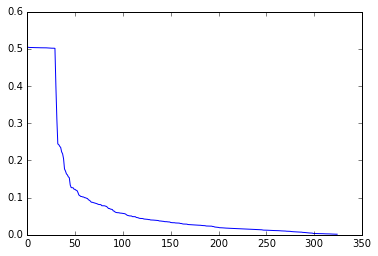

In [99]:
plt.plot(all_aps) # ap over 327 norms (Concepts)
plt.show()

In [100]:
top20norms_by_ap

,Concepts,AP
0,rat,0.504355
1,pant,0.504157
2,turkey,0.503563
3,canoe,0.503563
4,eagle,0.503365
5,pineapple,0.503365
6,flea,0.503365
7,peacock,0.503167
8,wasp,0.503167
9,parakeet,0.503167


In [101]:
bottom20norms_by_ap

,Concepts,AP
0,frog,0.003167
1,orange,0.003167
2,bathtub,0.003167
3,van,0.002969
4,stereo,0.002969
5,kite,0.002771
6,whistle,0.002771
7,plug,0.002573
8,grasshopper,0.002573
9,microscope,0.002573


In [102]:
top10predprops_df

,Feature,Count,Distinctiveness
0,made_of_wood,160,0.012658
1,made_of_metal,91,0.007519
2,is_round,57,0.013158
3,is_large,54,0.009434
4,different_colours,48,0.017241
5,is_long,47,0.012346
6,used_for_transportation,39,0.030303
7,is_small,35,0.008264
8,has_a_knob,33,1.000000
9,has_wheels,32,0.043478


In [103]:
selected_norm_top_df

,cat,gate,book,cigarette,drain
0,is_round,has_a_handle,made_of_wood,has_an_engine,is_dangerous
1,made_of_wood,has_a_lock,has_wheels,made_of_metal,is_tall
2,is_heavy,has_wheels,made_of_metal,made_of_glass,has_legs
3,made_of_metal,used_for_dividing_rooms,is_small,made_of_wood,made_of_metal
4,is_formal,made_of_metal,is_green,is_expensive,made_of_wood
5,used_for_construction,used_for_transportation,has_a_handle,used_by_bouncing,used_for_construction
6,is_expensive,used_for_cruising,is_expensive,is_furry,made_of_leather
7,is_hard,made_of_wood,has_an_engine,has_doors,made_of_brick
8,is_long,used_for_living_in,is_black,has_bedrooms,used_on_water
9,different_colours,is_green,is_long,is_edible,furniture


In [104]:
selected_norm_bottom_df

,cat,gate,book,cigarette,drain
0,has_black_spots,used_for_browning_bread,a_lingerie,worn_over_clothes,worn_with_suits
1,eg_-_jeans,is_climbed,is_convertible,has_a_balcony,used_for_loosening_screws
2,beh_-_sucks_blood,has_an_oven,used_for_storing_cups,used_for_wiping_hands,is_attached_by_string
3,used_by_boys,hunted_by_Eskimos,used_for_rocking,used_as_a_home_by_bees,used_for_storing_hay
4,used_in_deserts,eg_-_vanilla_cake,associated_with_winter,used_in_deserts,made_of_paper
5,has_a_balcony,used_for_holding_liquids,inbeh_-_produces_honey,used_for_learning,lives_in_Antarctic
6,used_for_holding_boats_still,used_for_bodily_functions,a_small_horse,has_hair,used_for_surgery
7,used_for_keeping_fish,used_by_gardeners,found_in_cartoons,used_with_paddles,beh_-_chases_cats
8,used_for_freezing,beh_-_suckles_milk,has_black_spots,used_for_controlling_the_cursor,used_for_boats
9,associated_with_winter,eaten_by_steaming,eg_-_jeans,made_of_grass,bought/sold_in_stores


##### CV = 10

In [40]:
# %%time
# wpmbtm = WPMBTM(norms, props, norm2prop, norm2propprob, dep_triples)
# wpmbtm.infer(cv=10)

In [41]:
# %%time
# wpmbtm.evaluate()